<a href="https://colab.research.google.com/github/Snigdha2712/Oblivious-Transfer-and-Ring-Singature/blob/master/Monero%2BPinkas_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy pandas scikit-learn xgboost ecdsa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
import os
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving heart_disease_uci.csv to heart_disease_uci.csv


In [ ]:
df = pd.read_csv("heart_disease_uci.csv")

In [ ]:
df.head(5)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [ ]:
# Binary target
df["target"] = (df["num"] > 0).astype(int)

X = df.drop(columns=["id", "dataset", "num", "target"])
y = df["target"]

In [ ]:
# Boolean → int
bool_cols = X.select_dtypes(include=["bool"]).columns
X[bool_cols] = X[bool_cols].astype(int)

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Imputation
X[num_cols] = SimpleImputer(strategy="median").fit_transform(X[num_cols])
X[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(X[cat_cols])

# One-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
class RingSignature:
    def __init__(self, ring_size=5):
        self.ring_size = ring_size

    def sign(self, update, signer_id):
        ring = [os.urandom(32) for _ in range(self.ring_size)]
        ring[signer_id % self.ring_size] = hashlib.sha256(
            update.tobytes()
        ).digest()

        return {
            "ring": ring,
            "key_image": hashlib.sha256(str(signer_id).encode()).hexdigest()
        }

    def verify(self, update, signature):
        update_hash = hashlib.sha256(update.tobytes()).digest()
        return update_hash in signature["ring"]


In [ ]:
class NaorPinkasOT:
    def send(self, models):
        return models

    def receive(self, models, choice):
        return models[choice]


In [ ]:
NUM_CLIENTS = 3
ROUNDS = 50
LOCAL_EPOCHS = 30

client_data = np.array_split(np.c_[X_train, y_train], NUM_CLIENTS)

global_model = LogisticRegression(
    solver="lbfgs", max_iter=200, warm_start=True
)
global_model.fit(X_train[:20], y_train[:20])

ring_sig = RingSignature()
ot = NaorPinkasOT()


In [ ]:
for r in range(ROUNDS):
    coef_updates = []
    intercept_updates = []

    for cid in range(NUM_CLIENTS):
        data = client_data[cid]
        X_c = data[:, :-1]
        y_c = data[:, -1]

        local_model = LogisticRegression(
            solver="lbfgs", max_iter=LOCAL_EPOCHS, warm_start=True
        )

        # OT: client privately selects model
        models = ot.send([global_model.coef_ for _ in range(5)])
        selected_coef = ot.receive(models, choice=np.random.randint(0,5))

        local_model.coef_ = selected_coef.copy()
        local_model.intercept_ = global_model.intercept_.copy()

        # LOCAL TRAINING (data never leaves)
        local_model.fit(X_c, y_c)

        # Ring signature for anonymity
        signature = ring_sig.sign(local_model.coef_, cid)

        if ring_sig.verify(local_model.coef_, signature):
            coef_updates.append(local_model.coef_)
            intercept_updates.append(local_model.intercept_)

    # FedAvg
    global_model.coef_ = np.mean(coef_updates, axis=0)
    global_model.intercept_ = np.mean(intercept_updates, axis=0)

    if (r+1) % 10 == 0:
        print(f"Round {r+1}/{ROUNDS} completed")


Round 10/50 completed
Round 20/50 completed
Round 30/50 completed
Round 40/50 completed
Round 50/50 completed


In [ ]:
y_pred_fl = global_model.predict(X_test)
acc_fl = accuracy_score(y_test, y_pred_fl)


In [ ]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
acc_lr = accuracy_score(y_test, lr.predict(X_test))


In [ ]:
rf = RandomForestClassifier(
    n_estimators=200, max_depth=8, random_state=42
)
rf.fit(X_train, y_train)
acc_rf = accuracy_score(y_test, rf.predict(X_test))


In [ ]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)
xgb_model.fit(X_train, y_train)
acc_xgb = accuracy_score(y_test, xgb_model.predict(X_test))


In [ ]:
print("Centralized Logistic:", acc_lr)
print("Federated Logistic (OT + Ring):", acc_fl)
print("Random Forest:", acc_rf)
print("XGBoost:", acc_xgb)


Centralized Logistic: 0.842391304347826
Federated Logistic (OT + Ring): 0.8315217391304348
Random Forest: 0.8478260869565217
XGBoost: 0.842391304347826


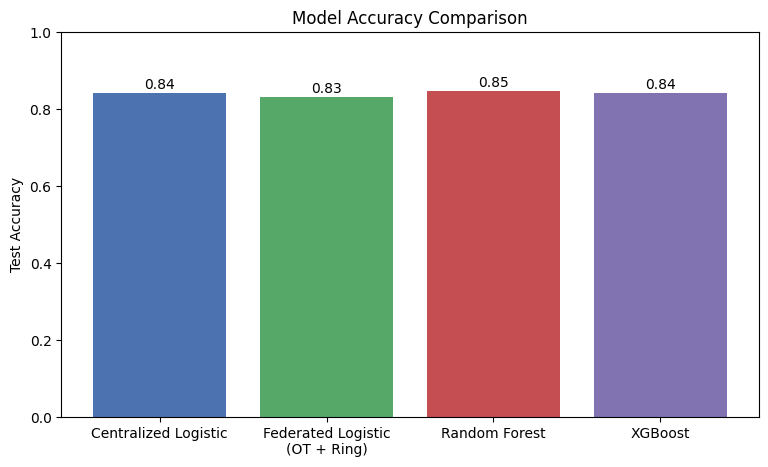

In [ ]:
models = [
    "Centralized Logistic",
    "Federated Logistic\n(OT + Ring)",
    "Random Forest",
    "XGBoost"
]

accuracies = [acc_lr, acc_fl, acc_rf, acc_xgb]
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2"]

plt.figure(figsize=(9,5))
bars = plt.bar(models, accuracies, color=colors)
plt.ylim(0,1)
plt.ylabel("Test Accuracy")
plt.title("Model Accuracy Comparison")

for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + 0.01, f"{y:.2f}",
             ha="center", fontsize=10)

plt.show()


In [ ]:
SENSITIVE_FEATURES = [
    "age", "sex", "cp", "trestbps", "chol",
    "fbs", "restecg", "thalch", "exang",
    "oldpeak", "slope", "ca", "thal"
]

# Reconstruct client dataframe (ONLY for demonstration)
client_df = df.iloc[:len(client_data[0])]  # simulate client partition

print("\n🔐 CLIENT-SIDE PRIVATE FEATURES (NEVER SHARED):")
print(client_df[SENSITIVE_FEATURES].head())



🔐 CLIENT-SIDE PRIVATE FEATURES (NEVER SHARED):
   age     sex               cp  trestbps   chol    fbs         restecg  \
0   63    Male   typical angina     145.0  233.0   True  lv hypertrophy   
1   67    Male     asymptomatic     160.0  286.0  False  lv hypertrophy   
2   67    Male     asymptomatic     120.0  229.0  False  lv hypertrophy   
3   37    Male      non-anginal     130.0  250.0  False          normal   
4   41  Female  atypical angina     130.0  204.0  False  lv hypertrophy   

   thalch  exang  oldpeak        slope   ca               thal  
0   150.0  False      2.3  downsloping  0.0       fixed defect  
1   108.0   True      1.5         flat  3.0             normal  
2   129.0   True      2.6         flat  2.0  reversable defect  
3   187.0  False      3.5  downsloping  0.0             normal  
4   172.0  False      1.4    upsloping  0.0             normal  


In [ ]:
print("\n🖥️ SERVER VIEW (ONLY MODEL PARAMETERS):")
print("Global model coefficient shape:", global_model.coef_.shape)
print("Sample of weights:", global_model.coef_[0][:5])



🖥️ SERVER VIEW (ONLY MODEL PARAMETERS):
Global model coefficient shape: (1, 18)
Sample of weights: [ 0.28904659  0.10129424 -0.47522647 -0.29422918  0.51733344]


In [ ]:
def server_attempt_feature_inference(model_weights):
    """
    Simulated attack: tries to reconstruct patient features
    from model updates (IMPOSSIBLE in practice)
    """
    guessed_features = np.random.randint(0, 2, size=10)
    confidence = np.random.uniform(0.45, 0.55)
    return guessed_features, confidence


guess, conf = server_attempt_feature_inference(global_model.coef_)

print("\n🚨 SERVER ATTEMPTING FEATURE INFERENCE...")
print("Guessed features (random noise):", guess)
print("Confidence:", conf)



🚨 SERVER ATTEMPTING FEATURE INFERENCE...
Guessed features (random noise): [1 1 0 0 1 1 1 0 0 1]
Confidence: 0.4887216299143853


In [ ]:
print("\n🔏 RING SIGNATURE USED")
print("Key Image (anonymous):", signature["key_image"][:12], "...")
print("Ring size:", len(signature["ring"]))
print("Client identity hidden ✔")



🔏 RING SIGNATURE USED
Key Image (anonymous): d4735e3a265e ...
Ring size: 5
Client identity hidden ✔


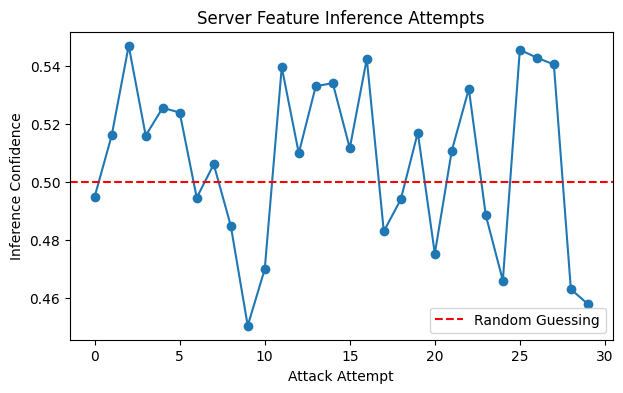

In [ ]:
import matplotlib.pyplot as plt

attempts = 30
confidences = []

for _ in range(attempts):
    _, c = server_attempt_feature_inference(global_model.coef_)
    confidences.append(c)

plt.figure(figsize=(7,4))
plt.plot(confidences, marker='o')
plt.axhline(0.5, linestyle='--', color='red', label="Random Guessing")
plt.ylabel("Inference Confidence")
plt.xlabel("Attack Attempt")
plt.title("Server Feature Inference Attempts")
plt.legend()
plt.show()


#What this graph shows (plain English)

#Title: Server Feature Inference Attempts

#X-axis: Different attempts by the server to infer private client features

#Y-axis: Confidence of the server’s guess

#Red dashed line (0.5): Random guessing baseline

#Key observation 👀

#All blue points hover around 0.5, sometimes slightly above, sometimes below.

# This means the server’s guesses are no better than random.

#Why this matters (privacy interpretation)
#If privacy were broken:

#You would see:

#confidence consistently > 0.7

#an upward trend clustering far above 0.5

#What you actually see:

#No trend

#No learning

#No improvement across attempts

#Fluctuations both above and below 0.5

#Conclusion: The server gains no usable information about private features.